In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torchvision.transforms as transforms
import torchvision.datasets as dset
from PIL import Image
import matplotlib.pyplot as plt

try:
    device = torch.device("cuda:1")
    is_cuda = True
except:
    device = torch.device("cpu")
    is_cuda = False

In [161]:
import torch
import torch.nn as nn


class NeuralOT(nn.Module):
    def __init__(self, source_dual_net, target_dual_net, source_to_target_net, regularization_parameter=1e-1,
                 regularization_mode='entropy', from_discrete=False, to_discrete=False):
        super().__init__()
        self.u = source_dual_net
        self.v = target_dual_net
        self.f = source_to_target_net
        self.eps = regularization_parameter
        if regularization_mode not in ['entropy', 'l2']:
            raise ValueError("``regularization_mode`` must be ``'entropy'`` or ``'l2'``.")
        self.mode = regularization_mode
        self.from_discrete = from_discrete
        self.to_discrete = to_discrete

    @staticmethod
    def squared_l2_distances(x, y):
        """
        Parameters
        ----------
        x : torch.tensor
            Batch of images from source domain of shape ``(N_s, C, H, W)``.
        y : torch.tensor
            Batch of images from target domain of shape ``(N_t, C, H, W)``.

        Returns
        -------
        distances : torch.tensor
            Tensor of shape ``(N_s, N_t)`` with pairwise l2 distances between source and target images.
        """
        return torch.sum((x[:, None] - y) ** 2, dim=(-3, -2, -1))

    def plan_criterion(self, x_idx, x, y_idx, y):
        """
        Parameters
        ----------
        x_idx : torch.tensor
            Batch of indices of shape ``(N,)``.
        x : torch.tensor
            Batch of images from source domain of shape ``(N, C, H, W)``.
        y_idx : torch.tensor
            Batch of indices of shape ``(N,)``.
        y : torch.tensor
            Batch of images from target domain of shape ``(N, C, H, W)``.

        Returns
        -------
        loss : torch.tensor
            Loss for training dual neural networks.
        """
        self.u.train()
        self.v.train()
        u = self.u(x_idx) if self.from_discrete else self.u(x)
        v = self.v(y_idx) if self.to_discrete else self.v(y)
        c = self.squared_l2_distances(x, y)

        if self.mode == 'entropy':
            regularization_term = -self.eps * torch.exp((u[:, None] + v - c) / self.eps)
        else:
            regularization_term = -torch.relu(u[:, None] + v - c) ** 2 / (4 * self.eps)

        return -torch.mean(u[:, None] + v + regularization_term)

    def mapping_criterion(self, x_idx, x, y_idx, y):
        """
        Parameters
        ----------
        x_idx : torch.tensor
            Batch of indices of shape ``(N,)``.
        x : torch.tensor
            Batch of images from source domain of shape ``(N, C, H, W)``.
        y_idx : torch.tensor
            Batch of indices of shape ``(N,)``.
        y : torch.tensor
            Batch of images from target domain of shape ``(N, C, H, W)``.

        Returns
        -------
        loss : torch.tensor
            Loss for training mapping neural network.
        """
        self.u.eval()
        self.v.eval()
        self.f.train()
        u = self.u(x_idx).detach() if self.from_discrete else self.u(x).detach()
        v = self.v(y_idx).detach() if self.to_discrete else self.v(y).detach()
        c = self.squared_l2_distances(x, y)
        mapped = self.f(x)  # shape ``(N, C, H, W)``

        d = self.squared_l2_distances(mapped, y)
        if self.mode == 'entropy':
            h = torch.exp((u[:, None] + v - c) / self.eps)
        else:
            h = torch.relu(u[:, None] + v - c) / (2 * self.eps)

        return torch.mean(d * h)

    def map(self, x):
        self.f.eval()
        return self.f(x)


class Unflatten(nn.Module):
    def __init__(self, *spatial):
        super().__init__()
        self.spatial = spatial

    def forward(self, x):
        return x.reshape(len(x), 1, *self.spatial)


class Vector(nn.Module):
    def __init__(self, initial):
        super().__init__()
        self.v = nn.Parameter(initial)

    def forward(self, idx):
        return self.v[idx]

In [162]:
def train(epochs, model, criterion, optimizer, train_loader, val_loader=None, scheduler=None, verbose=True, save_dir=None):
    model.to(device)
    for epoch in range(1, epochs+1):
        model.train()
        loss_avg = 0
        for batch in train_loader:
            for i in range(len(batch)):
                batch[i] = batch[i].to(device)
            optimizer.zero_grad()
            loss = criterion(*batch)
            loss_avg += loss.item()
            loss.backward()
            optimizer.step()
        loss_avg /= len(train_loader)
        
        model.eval()
        val_loss = 0
        if val_loader:
            with torch.no_grad():
                for batch in val_loader:
                    for i in range(len(batch)):
                        batch[i] = batch[i].to(device)
                    val_loss += criterion(*batch)
            val_loss /= len(val_loader)
         
            if scheduler is not None:
                scheduler.step(val_loss)
        else:
            if scheduler is not None:
                scheduler.step(loss_avg)
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            if val_loader:
                print('Epoch {}/{} || Loss:  Train {:.6g} | Validation {:.6g}'.format(epoch, epochs, loss_avg, val_loss.item()))
            else:
                print('Epoch {}/{} || Loss:  Train {:.6g}'.format(epoch, epochs, loss_avg))

In [163]:
class UniformSampler:
    """
    UniformSampler allows to sample batches in random manner without splitting the original data.
    """
    def __init__(self, datasets, batch_size=1, n_batches=1):
        if not isinstance(datasets, list):
            datasets = [datasets]
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.weights = [torch.ones(len(dset)) for dset in datasets]

    def __iter__(self):
        for i in range(self.n_batches):
            idx = [torch.multinomial(w, self.batch_size, replacement=True) for w in self.weights]
            yield torch.stack(idx, dim=1).squeeze()

    def __len__(self):
        return self.batch_size*self.n_batches

class ZipDataset(Dataset):
    """
    ZipDataset represents a dataset that stores several other datasets zipped together.
    """
    def __init__(self, datasets, return_idx=True):
        super().__init__()
        self.datasets = datasets
        self.return_idx = return_idx

    def __getitem__(self, idx):
        items = []
        for ids, dset in zip(idx, self.datasets):
            if self.return_idx:
                items.append(ids)
            items.append(dset[ids][0])

        if len(items) == 1:
            items = items[0]
        
        return items 

    def __len__(self):
        return max([len(dset) for dset in self.datasets])

class ZipLoader(DataLoader):
    def __init__(self, datasets, batch_size, n_batches, *args, return_idx=True, **kwargs):
        """
        ZipLoader allows to sample batches from zipped datasets with possibly different number of elements.
        """
        us = UniformSampler(datasets, batch_size=batch_size, n_batches=n_batches)
        dl = ZipDataset(datasets, return_idx=return_idx)
        self.size = max([len(dset) for dset in datasets])
        super().__init__(dl, *args, batch_sampler=us, **kwargs)
        
    def __len__(self):
        return self.size

In [164]:
class DistributionDataset():
    def __init__(self, distribution, transform=lambda x: x):
        super().__init__()
        self.distribution = distribution
        self.transform = transform
        
    def __getitem__(self, idx):
        return self.transform(self.distribution.sample()), None
    
    def __len__(self):
        return 1

In [165]:
def get_rotation(theta):
    rad = np.radians(theta)
    c, s = np.cos(rad), np.sin(rad)
    R = np.array([[c, -s],
                  [s,  c]])
    return R

from torch.distributions.multivariate_normal import MultivariateNormal

class CircleDataset():
    def __init__(self, n_samples, n_centers=9, sigma=0.02):
        super().__init__()
        self.nus = [torch.zeros(2)]
        self.sigma = sigma
        for i in range(n_centers-1):
            R = get_rotation(i*360/(n_centers-1))
            self.nus.append(torch.tensor([1, 0] @ R, dtype=torch.float))
        classes = torch.multinomial(torch.ones(n_centers), n_samples, 
                                    replacement=True)
        
        data = []
        for i in range(n_centers):
            n_samples_class = torch.sum(classes == i)
            if n_samples_class == 0:
                continue
            dist = MultivariateNormal(self.nus[i], 
                                      torch.eye(2)*self.sigma**2)
            data.append(dist.sample([n_samples_class.item()]))
        self.data = torch.cat(data)
        
    def __getitem__(self, idx):
        return self.data[idx], None
    
    def __len__(self):
        return self.data.shape[0]

In [166]:
class Vector(nn.Module):
    def __init__(self, n_dims):
        super().__init__()
        self.v = nn.Parameter(torch.zeros(n_dims))
        nn.init.xavier_uniform_(self.v[None, :])
    def forward(self, idx):
        return self.v[idx]

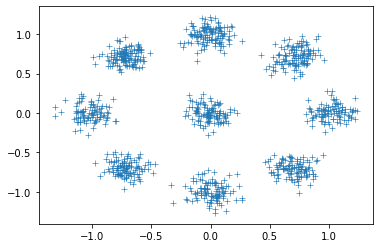

In [167]:
circle_dset = CircleDataset(1000, sigma=0.1)
plt.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], marker="+", lw=0.6)

In [168]:
n_samples = 1000
batch_size = 500
n_batches = n_samples//batch_size + 1

from torch.distributions.multivariate_normal import MultivariateNormal
distr = MultivariateNormal(torch.zeros(2), 0.4*torch.eye(2))
distr_dset = DistributionDataset(distr)
circle_dset = CircleDataset(n_samples, sigma=0.11)

gauss_loader = ZipLoader([distr_dset, circle_dset], batch_size=batch_size,
                     n_batches=n_batches)

In [171]:
d = []
for X, X_idx, Y, Y_idx in gauss_loader:
    d.append(torch.mean(NeuralOT.squared_l2_distances(X, Y)))
print("Average cost:", sum(d)/len(d))

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)

In [170]:
torch.manual_seed(1)

u = nn.Sequential(nn.Linear(2, 200),
                  nn.BatchNorm1d(200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 1000),
                  nn.BatchNorm1d(1000),
                  nn.SELU(),
                  nn.Linear(1000, 1)
                 )
# v = Vector(len(circle_dset))
v = nn.Sequential(nn.Linear(2, 200),
                  nn.BatchNorm1d(200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 1000),
                  nn.BatchNorm1d(1000),
                  nn.SELU(),
                  nn.Linear(1000, 1)
                 )

# torch.nn.init.normal_(v.v, 1.5, 0.5)
f = nn.Sequential(nn.Linear(2, 200),
                  nn.BatchNorm1d(200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 1000),
                  nn.BatchNorm1d(1000),
                  nn.SELU(),
                  nn.Linear(1000, 2)
                 )

model = NeuralOT(u, v, f, regularization_parameter=2e-2, regularization_mode='l2',
                 from_discrete=False, to_discrete=False)
# plan_optimizer = torch.optim.Adam(list(u.parameters())+[v.v], lr=1e-3)
plan_optimizer = torch.optim.Adam(list(u.parameters())+list(v.parameters()), lr=1e-4)
mapping_optimizer = torch.optim.Adam(f.parameters(), lr=1e-4)
plan_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(plan_optimizer, 
                                                            factor=0.5)
mapping_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mapping_optimizer, 
                                                               factor=0.5)

In [156]:
train(200, model, model.plan_criterion, plan_optimizer, gauss_loader,
      scheduler=plan_scheduler)

Epoch 10/200 || Loss:  Train -0.00062519
Epoch 20/200 || Loss:  Train -0.00133202
Epoch 30/200 || Loss:  Train -0.00144031
Epoch 40/200 || Loss:  Train -0.00146792
Epoch 50/200 || Loss:  Train -0.00138982
Epoch 60/200 || Loss:  Train -0.00131128
Epoch 70/200 || Loss:  Train -0.00139109
Epoch 80/200 || Loss:  Train -0.00144583
Epoch 90/200 || Loss:  Train -0.00146137
Epoch 100/200 || Loss:  Train -0.00143821
Epoch 110/200 || Loss:  Train -0.00141032
Epoch 120/200 || Loss:  Train -0.00142169
Epoch 130/200 || Loss:  Train -0.00138036
Epoch 140/200 || Loss:  Train -0.00136324
Epoch 150/200 || Loss:  Train -0.00149939
Epoch 160/200 || Loss:  Train -0.00142036
Epoch 170/200 || Loss:  Train -0.00143332
Epoch 180/200 || Loss:  Train -0.00149906
Epoch 190/200 || Loss:  Train -0.00137951
Epoch 200/200 || Loss:  Train -0.00145141


In [157]:
train(100, model, model.mapping_criterion, mapping_optimizer, gauss_loader,
      scheduler=mapping_scheduler)

Epoch 5/100 || Loss:  Train 0.00110219
Epoch 10/100 || Loss:  Train 0.00117757
Epoch 15/100 || Loss:  Train 0.00104829
Epoch 20/100 || Loss:  Train 0.000899199
Epoch 25/100 || Loss:  Train 0.0009447
Epoch 30/100 || Loss:  Train 0.000955367
Epoch 35/100 || Loss:  Train 0.000771049
Epoch 40/100 || Loss:  Train 0.000904282
Epoch 45/100 || Loss:  Train 0.000933971
Epoch 50/100 || Loss:  Train 0.00086732
Epoch 55/100 || Loss:  Train 0.000906288
Epoch 60/100 || Loss:  Train 0.000957424
Epoch 65/100 || Loss:  Train 0.000862539
Epoch 70/100 || Loss:  Train 0.000923591
Epoch 75/100 || Loss:  Train 0.000998064
Epoch 80/100 || Loss:  Train 0.00083822
Epoch 85/100 || Loss:  Train 0.00100324
Epoch 90/100 || Loss:  Train 0.000848872
Epoch 95/100 || Loss:  Train 0.000802282
Epoch 100/100 || Loss:  Train 0.000832247


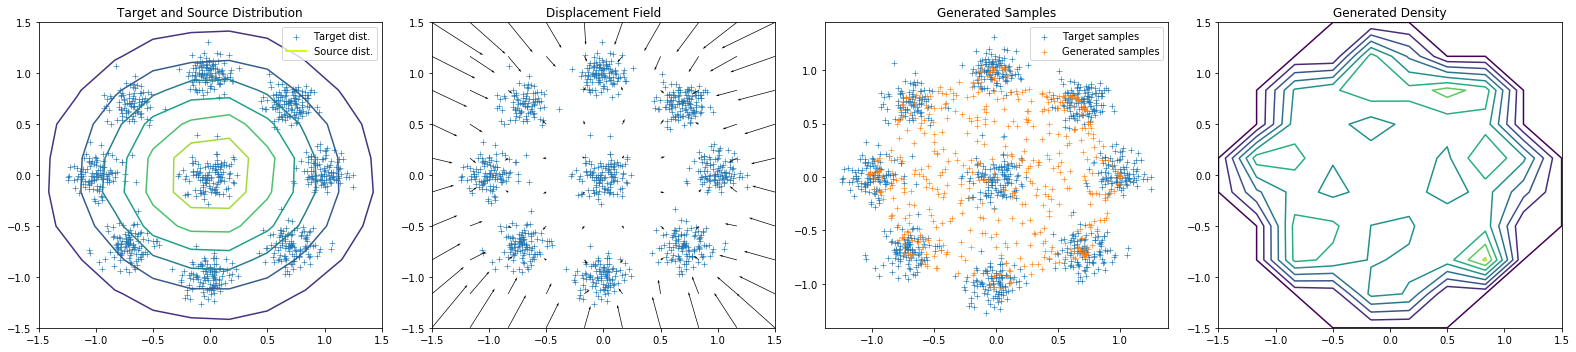

In [158]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

n_points = 100000
n_show = 500
xmin, xmax = -1.5, 1.5
ymin, ymax = -1.5, 1.5

idx = np.random.choice(np.arange(n_points, dtype=np.int), n_show,
                       replace=False)

ax = axes[0]
ps = distr.sample([n_points])
with torch.no_grad():
    ps_mapped = model.cpu().map(ps).detach().numpy()
ps = ps.numpy()
H, xedges, yedges = np.histogram2d(ps[:, 0], ps[:, 1], 
                                   range=[[xmin, xmax], [ymin, ymax]])

ax.contour(H.transpose(), extent=[xedges.min(), xedges.max(), 
                          yedges.min(), yedges.max()])
sc = ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6, label="Target dist.")
ax.set_title("Target and Source Distribution")
custom_lines = [sc, Line2D([0], [0], color=plt.cm.hsv(0.2), lw=2.)]
ax.legend(custom_lines, ["Target dist.", "Source dist."])

xs = np.linspace(xmin, xmax, num=10)
ys = np.linspace(ymin, ymax, num=10)

ax = axes[1]
XX, YY = np.meshgrid(xs, ys)
XX = torch.tensor(XX.ravel(), dtype=torch.float)
YY = torch.tensor(YY.ravel(), dtype=torch.float)

X = torch.stack([XX, YY], dim=1)
with torch.no_grad():
    Z = model.cpu().map(X).detach()
offsets = Z - X 

ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6)
ax.quiver(XX, YY, offsets[:, 0], offsets[:, 1], angles="xy", units="width",
          width=0.002)
ax.set_title("Displacement Field")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

with torch.no_grad():
    Z = model.cpu().map(X).detach()

ax = axes[2]
ax.set_title("Generated Samples")
ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6, label="Target samples")
ax.scatter(ps_mapped[idx, 0], ps_mapped[idx, 1], 
           marker="+", lw=0.6, label="Generated samples")
ax.legend()

ax = axes[3]
ax.set_title("Generated Density")
H, xedges, yedges = np.histogram2d(ps_mapped[:, 0], ps_mapped[:, 1], 
                                   range=[[xmin, xmax], [ymin, ymax]])

ax.contour(H.transpose(), extent=[xedges.min(), xedges.max(), 
                          yedges.min(), yedges.max()])
plt.tight_layout()
fig.savefig("gauss.pdf")
plt.show()

In [6]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(*self.shape)

In [10]:
h, w = 16, 16
batch_size = 1000

tr = transforms.Compose([transforms.Resize((h, w)),
                         transforms.ToTensor()])

mnist = dset.MNIST("data/mnist", download=True, transform=tr)
usps = dset.USPS("data/usps", download=True, transform=transforms.ToTensor())

n_batches = max(len(mnist), len(usps))//batch_size + 1
pairs_loader = ZipLoader([mnist, usps], batch_size=batch_size, n_batches=n_batches, 
                          pin_memory=is_cuda, return_idx=True)

for X, X_idx, Y, Y_idx in pairs_loader:
    print(X.shape, X_idx.shape, Y.shape, Y_idx.shape)
    break

torch.Size([1000, 1, 16, 16]) torch.Size([1000]) torch.Size([1000, 1, 16, 16]) torch.Size([1000])


In [19]:
u = Vector(len(mnist))
v = Vector(len(usps))
f = nn.Sequential(Reshape(-1, h*w),
                  nn.Linear(h*w, 200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.SELU(),
                  nn.Linear(500, h*w),
                  nn.Sigmoid(),
                  Reshape(-1, 1, h, w))

model = NeuralOT(u, v, f, regularization_parameter=1e-3, regularization_mode='l2',
                     from_discrete=True, to_discrete=True)
plan_optimizer = torch.optim.Adam([u.v, v.v], lr=1e-3)
mapping_optimizer = torch.optim.Adam(f.parameters(), lr=1e-3)
plan_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(plan_optimizer, 
                                                            factor=0.5)
mapping_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mapping_optimizer, 
                                                               factor=0.5)

In [9]:
train(30, model, model.plan_criterion, plan_optimizer, pairs_loader,
      scheduler=plan_scheduler)

Epoch 1/30 || Loss:  Train -0.0000
Epoch 2/30 || Loss:  Train -0.0000
Epoch 3/30 || Loss:  Train -0.0001
Epoch 4/30 || Loss:  Train -0.0001
Epoch 5/30 || Loss:  Train -0.0001
Epoch 6/30 || Loss:  Train -0.0002
Epoch 7/30 || Loss:  Train -0.0002
Epoch 8/30 || Loss:  Train -0.0002
Epoch 9/30 || Loss:  Train -0.0003
Epoch 10/30 || Loss:  Train -0.0003
Epoch 11/30 || Loss:  Train -0.0003
Epoch 12/30 || Loss:  Train -0.0003
Epoch 13/30 || Loss:  Train -0.0004
Epoch 14/30 || Loss:  Train -0.0004
Epoch 15/30 || Loss:  Train -0.0004
Epoch 16/30 || Loss:  Train -0.0004
Epoch 17/30 || Loss:  Train -0.0004
Epoch 18/30 || Loss:  Train -0.0004
Epoch 19/30 || Loss:  Train -0.0005
Epoch 20/30 || Loss:  Train -0.0005
Epoch 21/30 || Loss:  Train -0.0005
Epoch 22/30 || Loss:  Train -0.0005
Epoch 23/30 || Loss:  Train -0.0005
Epoch 24/30 || Loss:  Train -0.0005
Epoch 25/30 || Loss:  Train -0.0005
Epoch 26/30 || Loss:  Train -0.0005
Epoch 27/30 || Loss:  Train -0.0006
Epoch 28/30 || Loss:  Train -0.0006
E

In [ ]:
train(50, model, model.mapping_criterion, mapping_optimizer, pairs_loader,
      scheduler=mapping_scheduler)

Epoch 2/50 || Loss:  Train 0.0000
Epoch 4/50 || Loss:  Train 0.0000
Epoch 6/50 || Loss:  Train 0.0000
Epoch 8/50 || Loss:  Train 0.0000
Epoch 10/50 || Loss:  Train 0.0000
Epoch 12/50 || Loss:  Train 0.0000
Epoch 14/50 || Loss:  Train 0.0000
Epoch 16/50 || Loss:  Train 0.0000
Epoch 18/50 || Loss:  Train 0.0000
Epoch 20/50 || Loss:  Train 0.0000
Epoch 22/50 || Loss:  Train 0.0000
Epoch 24/50 || Loss:  Train 0.0000
Epoch 26/50 || Loss:  Train 0.0000
Epoch 28/50 || Loss:  Train 0.0000
Epoch 30/50 || Loss:  Train 0.0000
Epoch 32/50 || Loss:  Train 0.0000


In [ ]:
torch.save(model.cpu(), "model")

In [37]:
d = []
for X, X_idx, Y, Y_idx in pairs_loader:
    d.append(torch.mean(torch.sqrt(torch.sum((X-Y)**2, dim=(-1, -2, -3)))))
print("Average cost:", sum(d)/len(d))

Average cost: tensor(5.8444)


In [16]:
%%capture --no-stdout --no-display

import sys
sys.path.append('../neural-ot/')
print(sys.path)

n_samples = 5
model = torch.load("model_last")

fig, axes = plt.subplots(2, n_samples, figsize=(10, 6))

for i in range(n_cols):
    img = mnist[i][0]
    axes[0, i].imshow(img.squeeze(), cmap="Greys")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    mapped = model.map(img)
    axes[1, i].imshow(mapped.squeeze().detach().numpy(), cmap="Greys")
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
plt.tight_layout()
fig.savefig("test.png")

['/home/alartum/jupyter/ML/neural-ot/notebooks', '/home/alartum/miniconda/envs/gpu-torch/lib/python37.zip', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7/lib-dynload', '', '/home/alartum/.local/lib/python3.7/site-packages', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7/site-packages', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7/site-packages/IPython/extensions', '/home/alartum/.ipython', '../neural-ot/', '../neural-ot/']


ModuleNotFoundError: No module named 'framework'